# Ablation Study of Global Descriptors

In [1]:
# Activate (tranfor_python3_9)  enviromnemt

* import packges 

In [1]:
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from rich.console import Console
from rich.jupyter import print
from rich.table import Table
from scipy.stats import pearsonr, skew
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import PowerTransformer, StandardScaler

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)

In [2]:
df = pd.read_csv("data/groups/0.1/grouped_data.csv")
df.head()

,mobleyID,pol,psa,n_donors,nrotb,group_id,dG_exp,n_acceptors,logP
0,mobley_7532833,-7.491408,23.79,0,0,7.0,-3.88,1,0.52988
1,mobley_2198613,-1.497948,0.00,0,0,4.0,-0.63,0,1.24510
2,mobley_9257453,-9.095077,20.23,1,0,5.0,-7.29,1,2.69900
3,mobley_755351,-13.409148,35.25,1,1,5.0,-7.29,2,1.27740
4,mobley_9729792,-3.356425,0.00,0,0,NaN,-0.99,0,2.05870


## Group Mapping


In [3]:
console = Console()

# Map group_id to group names
group_names = {
    0: "Alkanol",
    1: "Alkanone",
    2: "Alkene",
    3: "Alkyl Alkanoate",
    4: "Halo Alkane",
    5: "Aromatic",
    6: "Aliphatic cyclic",
    7: "N-based Aliphatic",
}

# Add a new column for group names
df["group_name"] = df["group_id"].map(group_names)

##  The group disribution 


In [5]:
# Create a table for group distribution
group_distribution = df["group_name"].value_counts().reset_index()
group_distribution.columns = ["Group Name", "Count"]

table = Table(title="Group Distribution")
table.add_column("Group Name", justify="left", style="cyan", no_wrap=True)
table.add_column("Count", justify="right", style="green")

for index, row in group_distribution.iterrows():
    table.add_row(row["Group Name"], str(row["Count"]))

console.print(table)

# Visualize the distribution of groups using Plotly
fig = px.bar(
    group_distribution,
    x="Group Name",
    y="Count",
    title="Distribution of Groups",
    labels={"Group Name": "Group Name", "Count": "Number of Molecules"},
    text_auto=True,
)

fig.update_traces(
    marker_color="lightseagreen",
    marker_line_color="rgb(8,48,107)",
    marker_line_width=1.5,
    opacity=0.6,
)

fig.update_layout(
    xaxis_title="Group Name", yaxis_title="Number of Molecules", template="plotly_white"
)

fig.show()

     Group Distribution      
┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Group Name        ┃ Count ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ Aromatic          │   250 │
│ Halo Alkane       │    85 │
│ Alkyl Alkanoate   │    35 │
│ Alkanone          │    27 │
│ Alkene            │    26 │
│ Alkanol           │    24 │
│ N-based Aliphatic │    12 │
│ Aliphatic cyclic  │    12 │
└───────────────────┴───────┘

# Group statistics


In [4]:
console.print("[bold magenta]Basic Statistics:[/bold magenta]")
df.describe()

Basic Statistics:

,pol,psa,n_donors,nrotb,group_id,dG_exp,n_acceptors,logP
count,643.000000,643.000000,643.000000,643.000000,471.000000,643.000000,643.000000,643.000000
mean,-9.583435,20.889207,0.343701,1.629860,4.097665,-3.806952,1.382582,1.926940
std,10.516359,23.806500,0.627811,1.971726,1.576090,3.846124,1.610850,1.491136
min,-103.116055,0.000000,0.000000,0.000000,0.000000,-25.470000,0.000000,-3.585400
25%,-11.689927,0.000000,0.000000,0.000000,4.000000,-5.730000,0.000000,1.123300
50%,-7.678724,17.070000,0.000000,1.000000,5.000000,-3.540000,1.000000,1.780100
75%,-3.611565,26.300000,1.000000,3.000000,5.000000,-1.220000,2.000000,2.569650
max,-0.049148,136.100000,6.000000,12.000000,7.000000,3.430000,9.000000,9.887600


# Correlation and Heatmap

In [6]:
corr_matrix = df[["pol", "psa", "n_donors", "nrotb", "n_acceptors", "logP"]].corr()
#print(corr_matrix)


fig1 = go.Figure(
    data=go.Heatmap(
        z=corr_matrix.values,
        x=corr_matrix.columns,
        y=corr_matrix.columns,
        colorscale="Viridis",
        colorbar=dict(title="Correlation"),
        zmin=-1,  # Ensure the scale is from -1 to 1
        zmax=1,
    )
)

# Add annotations for correlation values
annotations = []
for i, row in enumerate(corr_matrix.values):
    for j, value in enumerate(row):
        annotations.append(
            go.layout.Annotation(
                text=f"{value:.2f}",  # Format to 2 decimal places
                x=corr_matrix.columns[j],
                y=corr_matrix.columns[i],
                xref="x1",
                yref="y1",
                font=dict(color="white" if abs(value) > 0.5 else "black"),
                showarrow=False,
            )
        )
fig1.update_layout(
    template="plotly_white",
    #xaxis_title="Features",
    #yaxis_title="Features",
    annotations=annotations,
    width=600,
    height=600,
    
    # Set font size for axis tick labels
    xaxis=dict(
        tickfont=dict(size=18),  # Adjust size here
        titlefont=dict(size=16)  # Optional: change x-axis title font size
    ),
    yaxis=dict(
        tickfont=dict(size=18),  # Adjust size here
        titlefont=dict(size=16)  # Optional: change y-axis title font size
    ),
)


fig1.show()
import plotly.io as pio

pio.write_image(fig1, "heatmap.png", format='png', width=600, height=600, scale=2)



# KDE Analysis

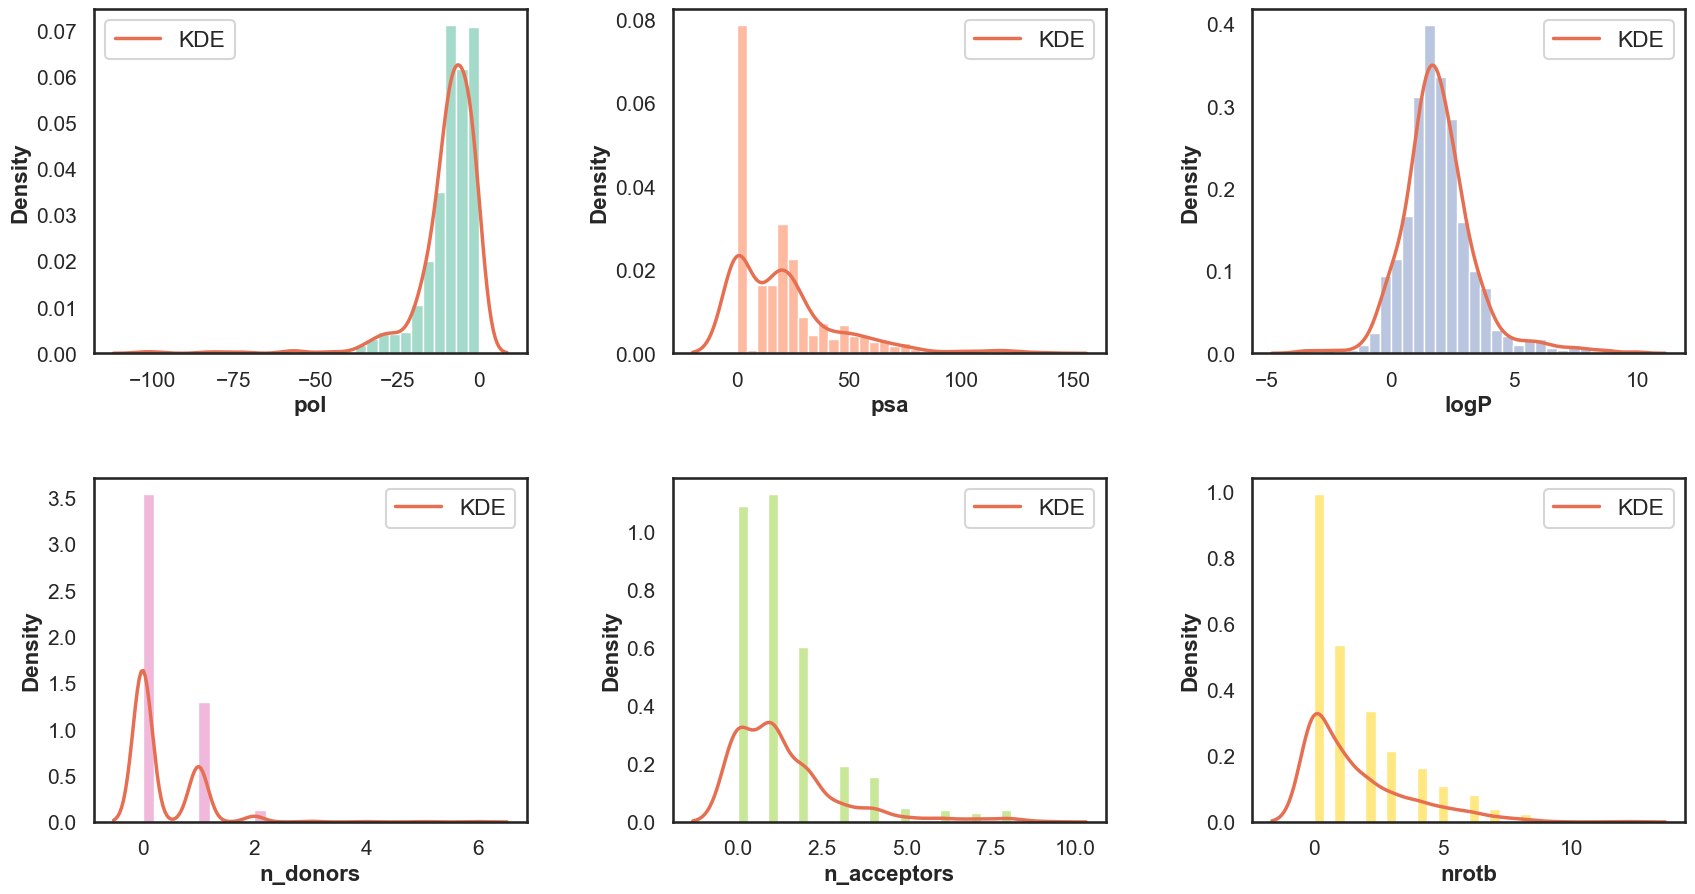

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Use default matplotlib style without grid
sns.set(style="white", context="talk")  # 'white' removes grid

# Feature list
features = ["pol", "psa", "logP", "n_donors", "n_acceptors", "nrotb"]

# Colors
cmap = plt.get_cmap('Set2')
colors = [cmap(i) for i in range(len(features))]  # Unique for each histogram
kde_color = "#e76f51"  # Single color for all KDEs

# Create subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, feat in enumerate(features):
    ax = axes[i]
    x_data = df[feat].dropna()

    # Plot histogram
    sns.histplot(
        x=x_data,
        kde=False,
        stat="density",
        color=colors[i],
        ax=ax,
        alpha=0.6,
        bins=30,
        edgecolor="white",
        linewidth=1.0
    )

    # KDE line
    if x_data.var() > 0:
        try:
            sns.kdeplot(
                x=x_data,
                color=kde_color,
                ax=ax,
                linewidth=2.5,
                label="KDE"
            )
        except np.linalg.LinAlgError:
            print(f"Singular matrix error for feature: {feat}")
    else:
        print(f"Skipping KDE for feature {feat} due to insufficient variance.")

    #ax.set_title(f"{feat}", fontsize=14, fontweight="bold")
    ax.set_xlabel(feat, fontsize=16, fontweight="bold")
    ax.set_ylabel("Density", fontsize=16, fontweight="bold")
    ax.tick_params(axis="both", labelsize=15)
    ax.grid(False)  # Turn off grid
    ax.legend()

# Title and layout
#fig.suptitle("Feature Distributions with Unique Histograms and Common KDE", fontsize=20, fontweight="bold", y=1.02)
plt.tight_layout(pad=2.5)

# Save high-res
plt.savefig("feature_distributions_KDE.png", dpi=300, bbox_inches='tight')
plt.show()
